## Plot carbon T-S distribution change

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data

filename = 'C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/WM_Methods/folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines()

chunks = {'time': 1, 'k': 25}
    
ECCO_THETA = xr.open_mfdataset(mylist[14], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_SALT = xr.open_mfdataset(mylist[15], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_Cstar = xr.open_mfdataset(mylist[19], decode_times=True, decode_cf=True, chunks = chunks)



OSError: no files to open

In [56]:
# Extract early and late periods

dyrs = 10
yr_init = 1992

init_early = 1995
init_late = 2005

month_init_early=(init_early-yr_init)*12
month_init_late=(init_late-yr_init)*12

Early_period = (np.array([month_init_early,month_init_early+dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+dyrs*12]))

print(Early_period[0])
print(Early_period[1])
print(Late_period[0])
print(Late_period[1])

THETA_early = ECCO_THETA.THETA.isel(time=slice(Early_period[0],Early_period[1])).mean('time',skipna=True).values
THETA_late = ECCO_THETA.THETA.isel(time=slice(Late_period[0],Late_period[1])).mean('time',skipna=True).values

SALT_early = ECCO_SALT.SALT.isel(time=slice(Early_period[0],Early_period[1])).mean('time',skipna=True).values
SALT_late = ECCO_SALT.SALT.isel(time=slice(Late_period[0],Late_period[1])).mean('time',skipna=True).values

Cstar_early = ECCO_Cstar.Cstar.isel(time=slice(Early_period[0],Early_period[1])).mean('time',skipna=True).values
Cstar_late = ECCO_Cstar.Cstar.isel(time=slice(Late_period[0],Late_period[1])).mean('time',skipna=True).values

Vol = (ECCO_THETA.rA * ECCO_THETA.drF * ECCO_THETA.hFacC * ECCO_THETA.maskC).values.transpose(3,0,1,2)

36
156
156
276


In [ ]:
# Bin into early and late TS bins

dT=0.2
dS=0.05

Tbins = np.array(np.arange(-5,35+dT,dT))
Sbins = np.array(np.arange(30,40+dS,dS))

C_early = np.empty((Sbins.size-1,Tbins.size-1))
C_early[:]=np.nan
C_late = np.empty((Sbins.size-1,Tbins.size-1))
C_late[:]=np.nan


for i in range(Sbins.size-1):
    print(i)
    for j in range(Tbins.size-1):
        
        C_early[i,j] = np.where((SALT_early >= Sbins[i]) & (SALT_early < Sbins[i+1]) & (THETA_early >= Tbins[j]) & (THETA_early < Tbins[j+1]), Cstar_early*Vol, 0).sum()
        C_late[i,j] = np.where((SALT_late >= Sbins[i]) & (SALT_late < Sbins[i+1]) & (THETA_late >= Tbins[j]) & (THETA_late < Tbins[j+1]), Cstar_late*Vol, 0).sum()
                                                                                                                           

18.61681504221189


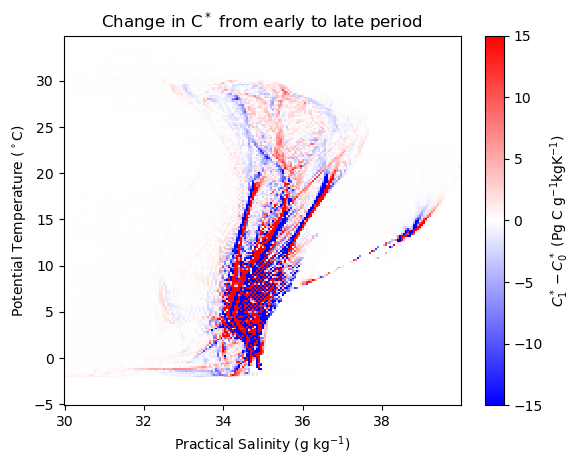

In [3]:
# Plot

carbon_TS = xr.open_mfdataset('carbon_TS.nc')

C_late = carbon_TS.C_late
C_early = carbon_TS.C_early
Sbins = carbon_TS.S.values
Tbins = carbon_TS.T.values
dS = Sbins[1]-Sbins[0]
dT = Tbins[1]-Tbins[0]

C_diff = C_late - C_early
C_diff_Pg = np.where(C_diff !=0, C_diff, np.nan)*12/10**18

plt.pcolormesh(Sbins,Tbins,C_diff_Pg.transpose()/(dT*dS),cmap=plt.cm.bwr,vmin=-15,vmax=15)
plt.colorbar(label='$C^*_1 - C^*_0$ (Pg C $\mathrm{g^{-1} kg K^{-1}}$)')
plt.xlabel('Practical Salinity (g kg$^{-1}$)')
plt.ylabel('Potential Temperature ($^\circ$C)')
plt.title('Change in $\mathrm{C^*}$ from early to late period')

plt.savefig('Cstar_TSdist.png',dpi=300,transparent=True)

print(np.nansum(C_diff_Pg))

array(0.2)

In [176]:
da_C_early = xr.DataArray(data = C_early, dims = ["S","T"], coords=dict(S=Sbins[0:-1], T=Tbins[0:-1]))
da_C_late = xr.DataArray(data = C_late, dims = ["S","T"], coords=dict(S=Sbins[0:-1], T=Tbins[0:-1]))

dataset=xr.Dataset()
dataset['C_early'] = da_C_early
dataset['C_late'] = da_C_late

dataset.to_netcdf('carbon_TS.nc')